References
Data: https://www.kaggle.com/datasets/rohanrao/air-quality-data-in-india/data
Notebooks:
1. https://www.kaggle.com/code/iamleonie/intro-to-time-series-forecasting#Models-for-Univariate-Time-Series
2. https://www.kaggle.com/code/aishwaryasarkar/india-s-aqi-eda-forecasting-sarima

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

Reading data

In [3]:
df= pd.read_csv('./data/city_day.csv')

In [4]:
# Obtaining data for Delhi only
city_df = df[df['City'] == 'Delhi'].copy()

In [5]:
# Covert the 'Date' column to datetime format
city_df['Date'] = pd.to_datetime(city_df['Date'])

In [6]:
# Dropping the 'City' column
city_df.drop(columns=['City'], inplace=True)

Ensuring chronological order

In [7]:
# Sort rows by the Date column (keeps default index)
city_df.sort_values('Date', inplace=True)

In [8]:
# Making sure there is a difference of one day between rows
(city_df['Date'] - city_df['Date'].shift(1)).value_counts()

Date
1 days    2008
Name: count, dtype: int64

Missing values

In [9]:
city_df.isna().sum().sort_values(ascending=False)

Xylene        781
SO2           110
O3             84
PM10           77
AQI            10
AQI_Bucket     10
NH3             9
PM2.5           2
NO2             2
NO              2
Date            0
NOx             0
CO              0
Benzene         0
Toluene         0
dtype: int64

In [10]:
# Setting 'Date' as index and sort
city_df = city_df.set_index('Date')

In [11]:

def plot_numeric_columns(df, num_cols):
    n = len(num_cols)
    if n == 0:
        raise SystemExit("No numeric columns to plot")

    # Creating one subplot per column (stacked)
    fig, axes = plt.subplots(nrows=n, ncols=1, figsize=(12, 3 * n), sharex=True)
    if n == 1:
        axes = [axes]
    for ax, col in zip(axes, num_cols):
        df[col].plot(ax=ax, legend=False)
        ax.set_title(col)
        ax.set_ylabel('Value')
    plt.xlabel('Date')
    plt.tight_layout()
    plt.show()

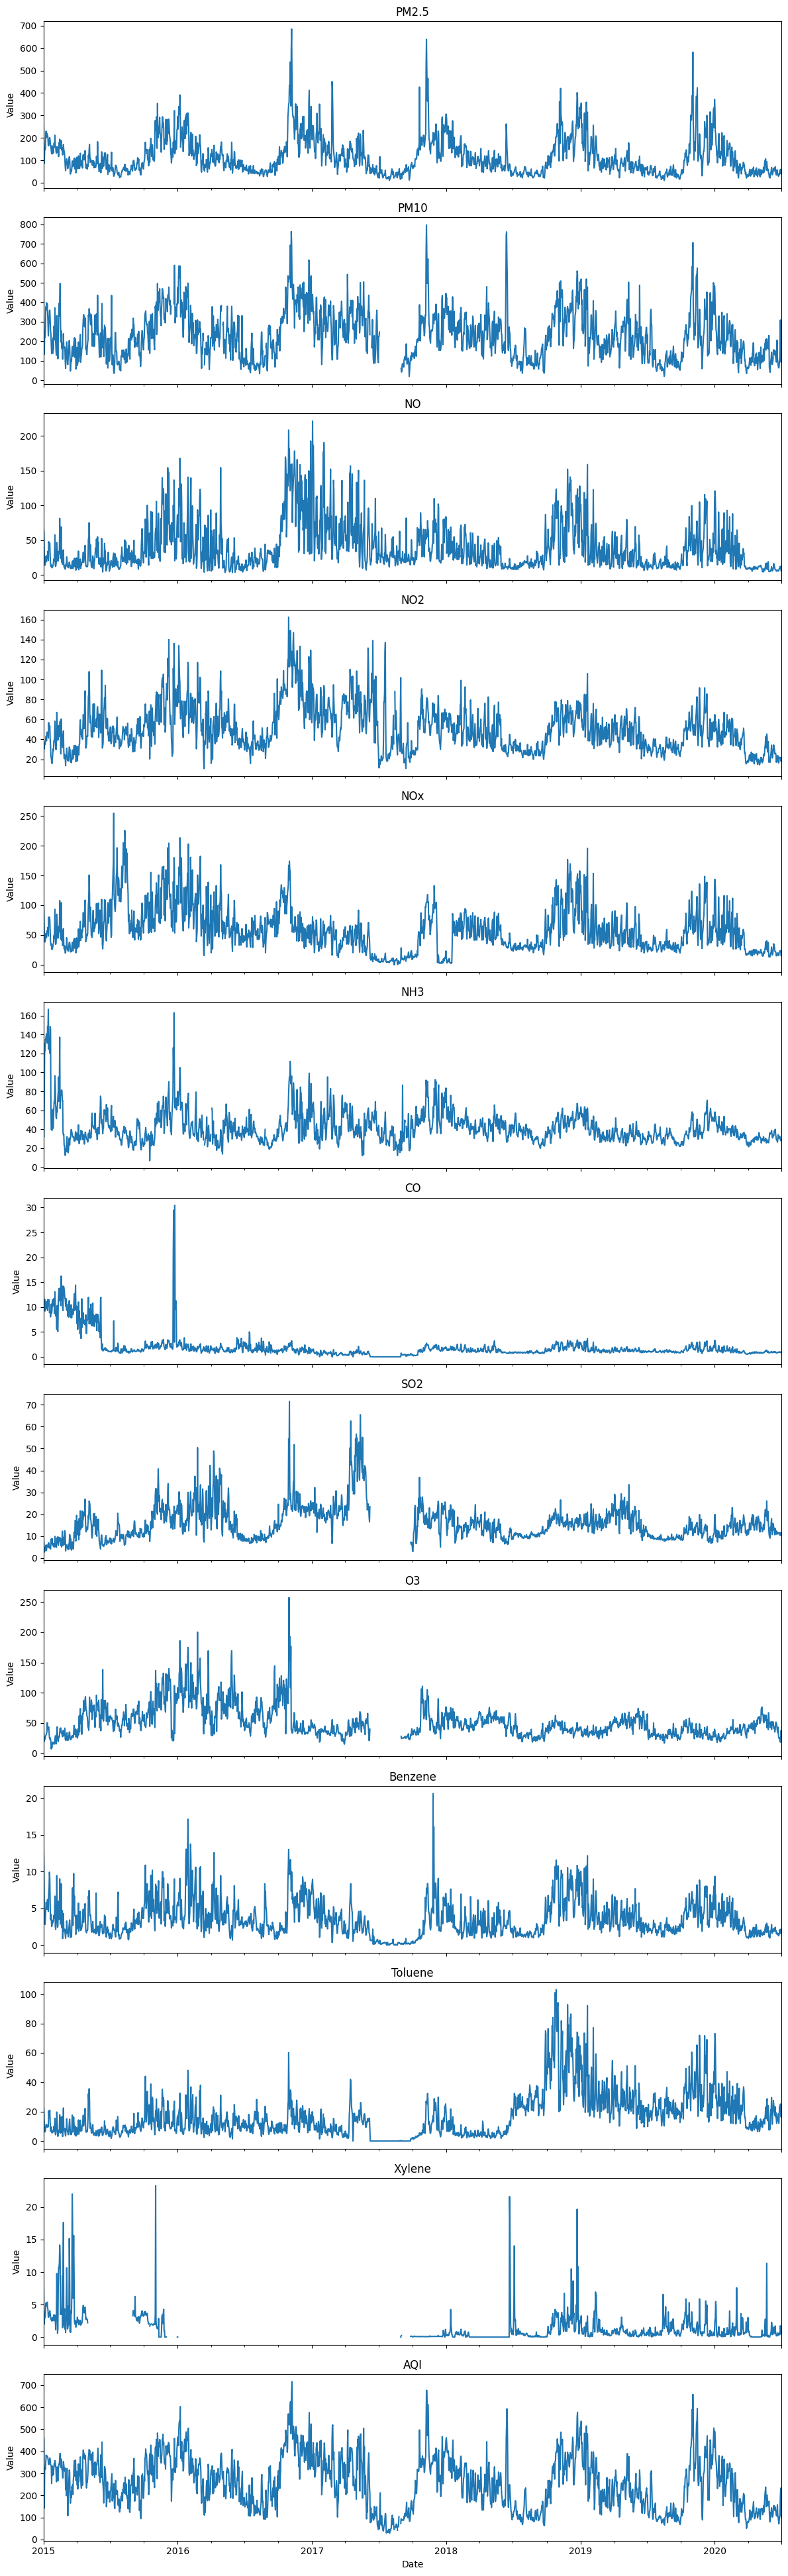

In [12]:
# Selecting numeric columns to plot
num_cols = city_df.select_dtypes(include='number').columns.tolist()

plot_numeric_columns(city_df, num_cols)

In [13]:
# Identifying the missing gaps in data

def find_gaps(pollutant_data):
    # pollutant_data = city_df[pollutant] 
    nan_idx = pollutant_data[pollutant_data.isna()].index

    if len(nan_idx) == 0:
        print("No gaps.")
    else:
        gaps = []
        start = nan_idx[0]
        prev = nan_idx[0]
        for d in nan_idx[1:]:
            if (d - prev) == pd.Timedelta(days=1):
                prev = d
                continue
            gaps.append((start, prev))
            start = d
            prev = d
        gaps.append((start, prev))

        for s, e in gaps:
            print(f"Missing from {s.date()} to {e.date()} — {(e - s).days + 1} days")

for i in num_cols:
    print(i)
    find_gaps(city_df[i])
    print()

PM2.5
Missing from 2017-08-12 to 2017-08-13 — 2 days

PM10
Missing from 2015-12-15 to 2015-12-21 — 7 days
Missing from 2016-03-12 to 2016-03-13 — 2 days
Missing from 2016-04-01 to 2016-04-02 — 2 days
Missing from 2016-04-16 to 2016-04-16 — 1 days
Missing from 2016-04-30 to 2016-05-02 — 3 days
Missing from 2016-08-27 to 2016-08-27 — 1 days
Missing from 2017-06-08 to 2017-06-08 — 1 days
Missing from 2017-06-10 to 2017-06-11 — 2 days
Missing from 2017-07-04 to 2017-08-30 — 58 days

NO
Missing from 2017-08-12 to 2017-08-13 — 2 days

NO2
Missing from 2017-08-12 to 2017-08-13 — 2 days

NOx
No gaps.

NH3
Missing from 2016-03-12 to 2016-03-13 — 2 days
Missing from 2016-04-01 to 2016-04-02 — 2 days
Missing from 2016-08-27 to 2016-08-27 — 1 days
Missing from 2017-08-12 to 2017-08-13 — 2 days
Missing from 2017-09-12 to 2017-09-13 — 2 days

CO
No gaps.

SO2
Missing from 2017-04-22 to 2017-04-22 — 1 days
Missing from 2017-06-08 to 2017-08-27 — 81 days
Missing from 2017-08-29 to 2017-09-25 — 28 days

<Axes: xlabel='Date'>

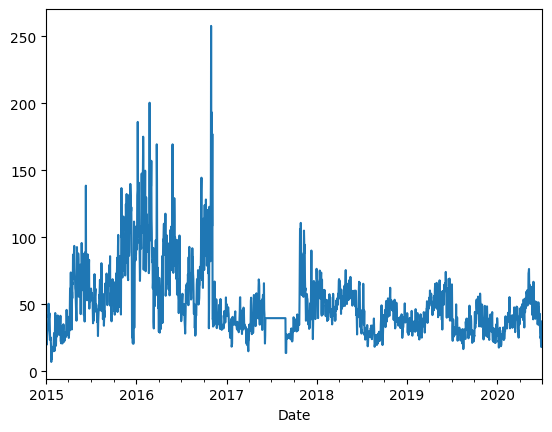

In [14]:
# This shows that filling forward for large gaps is not idea
city_df['O3'].ffill().plot()

In [15]:
threshold = 10

city_df = city_df.interpolate(method='time', limit=threshold, limit_direction='both')

C:\Users\Ryan\AppData\Local\Temp\ipykernel_19180\4281077530.py:3: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  city_df = city_df.interpolate(method='time', limit=threshold, limit_direction='both')


In [16]:
for i in num_cols:
    print(i)
    find_gaps(city_df[i])
    print()

PM2.5
No gaps.

PM10
Missing from 2017-07-14 to 2017-08-20 — 38 days

NO
No gaps.

NO2
No gaps.

NOx
No gaps.

NH3
No gaps.

CO
No gaps.

SO2
Missing from 2017-06-18 to 2017-08-17 — 61 days
Missing from 2017-09-08 to 2017-09-15 — 8 days

O3
Missing from 2017-06-18 to 2017-08-17 — 61 days

Benzene
No gaps.

Toluene
No gaps.

Xylene
Missing from 2015-05-12 to 2015-08-21 — 102 days
Missing from 2015-12-12 to 2015-12-20 — 9 days
Missing from 2016-01-12 to 2017-08-19 — 586 days

AQI
No gaps.



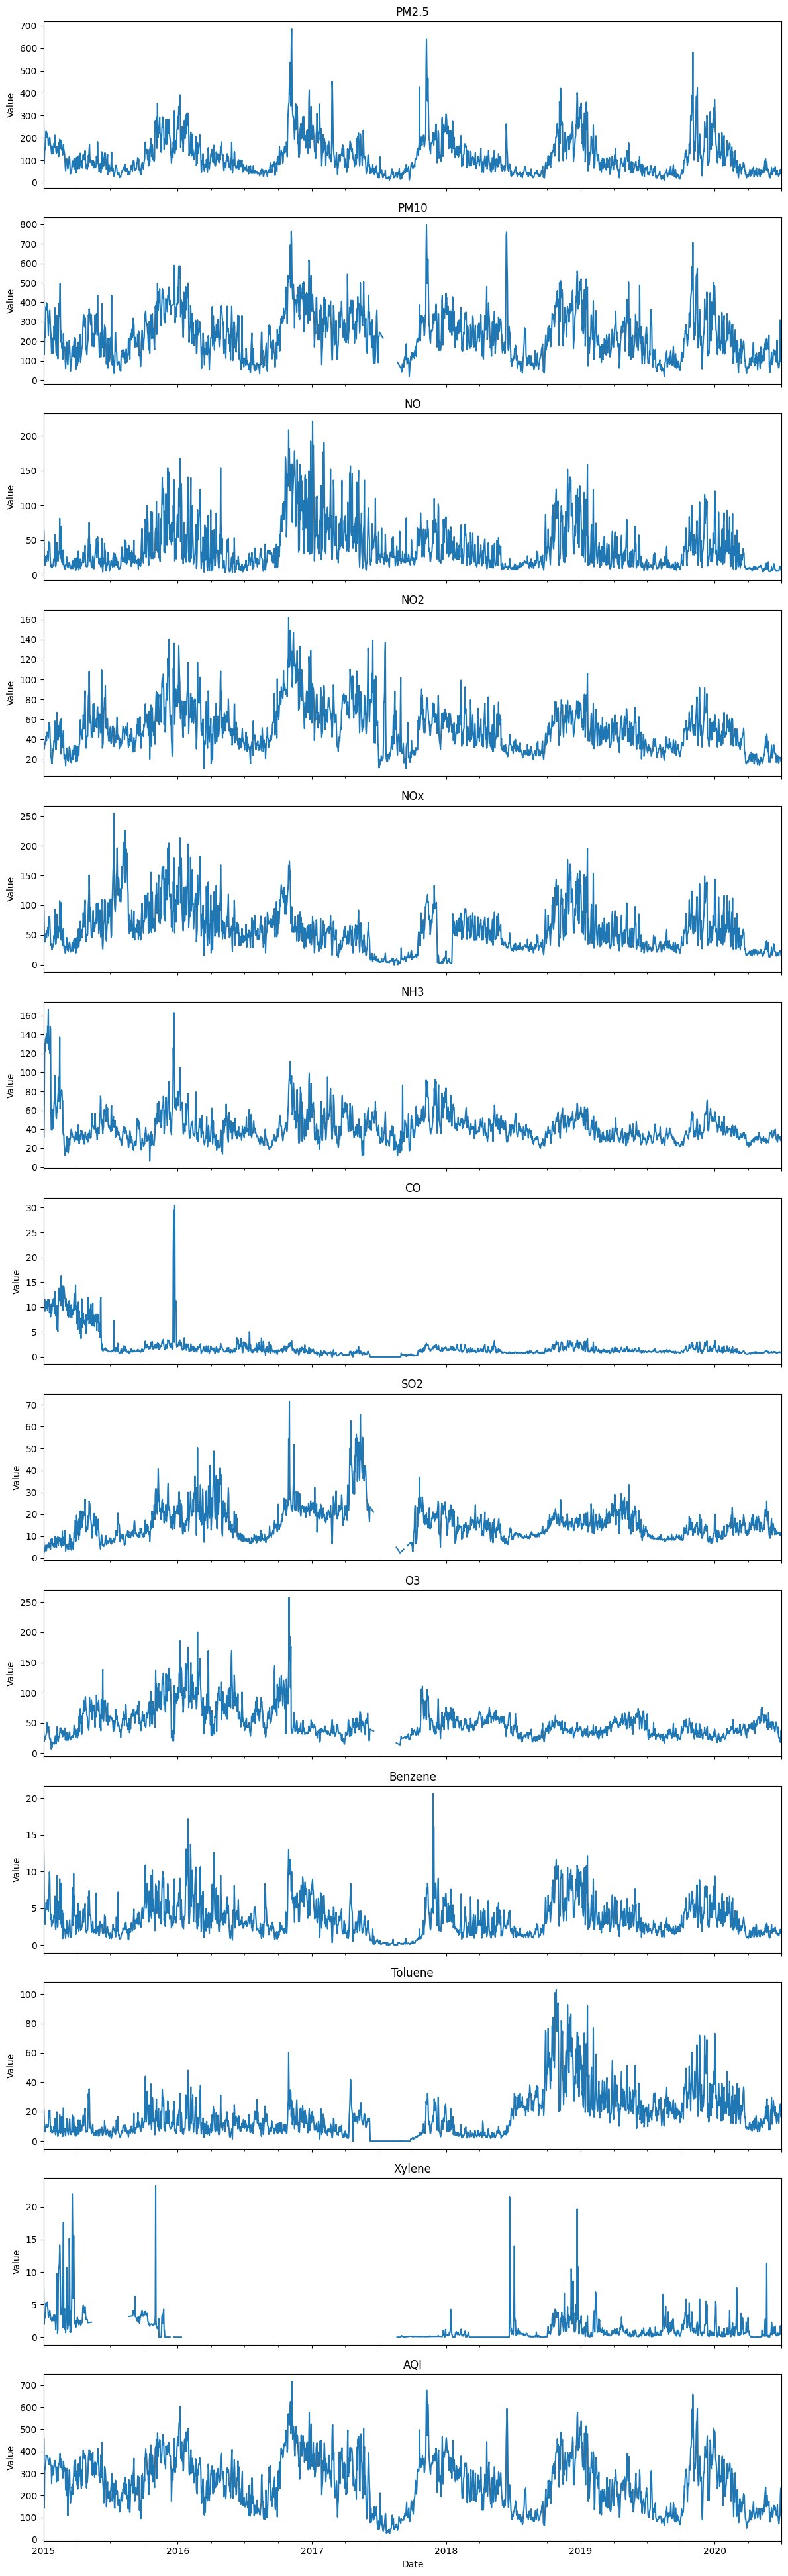

In [17]:
plot_numeric_columns(city_df, num_cols)

Resampling data

In [18]:
weekly_city_df = city_df.resample('W').mean(numeric_only=True)

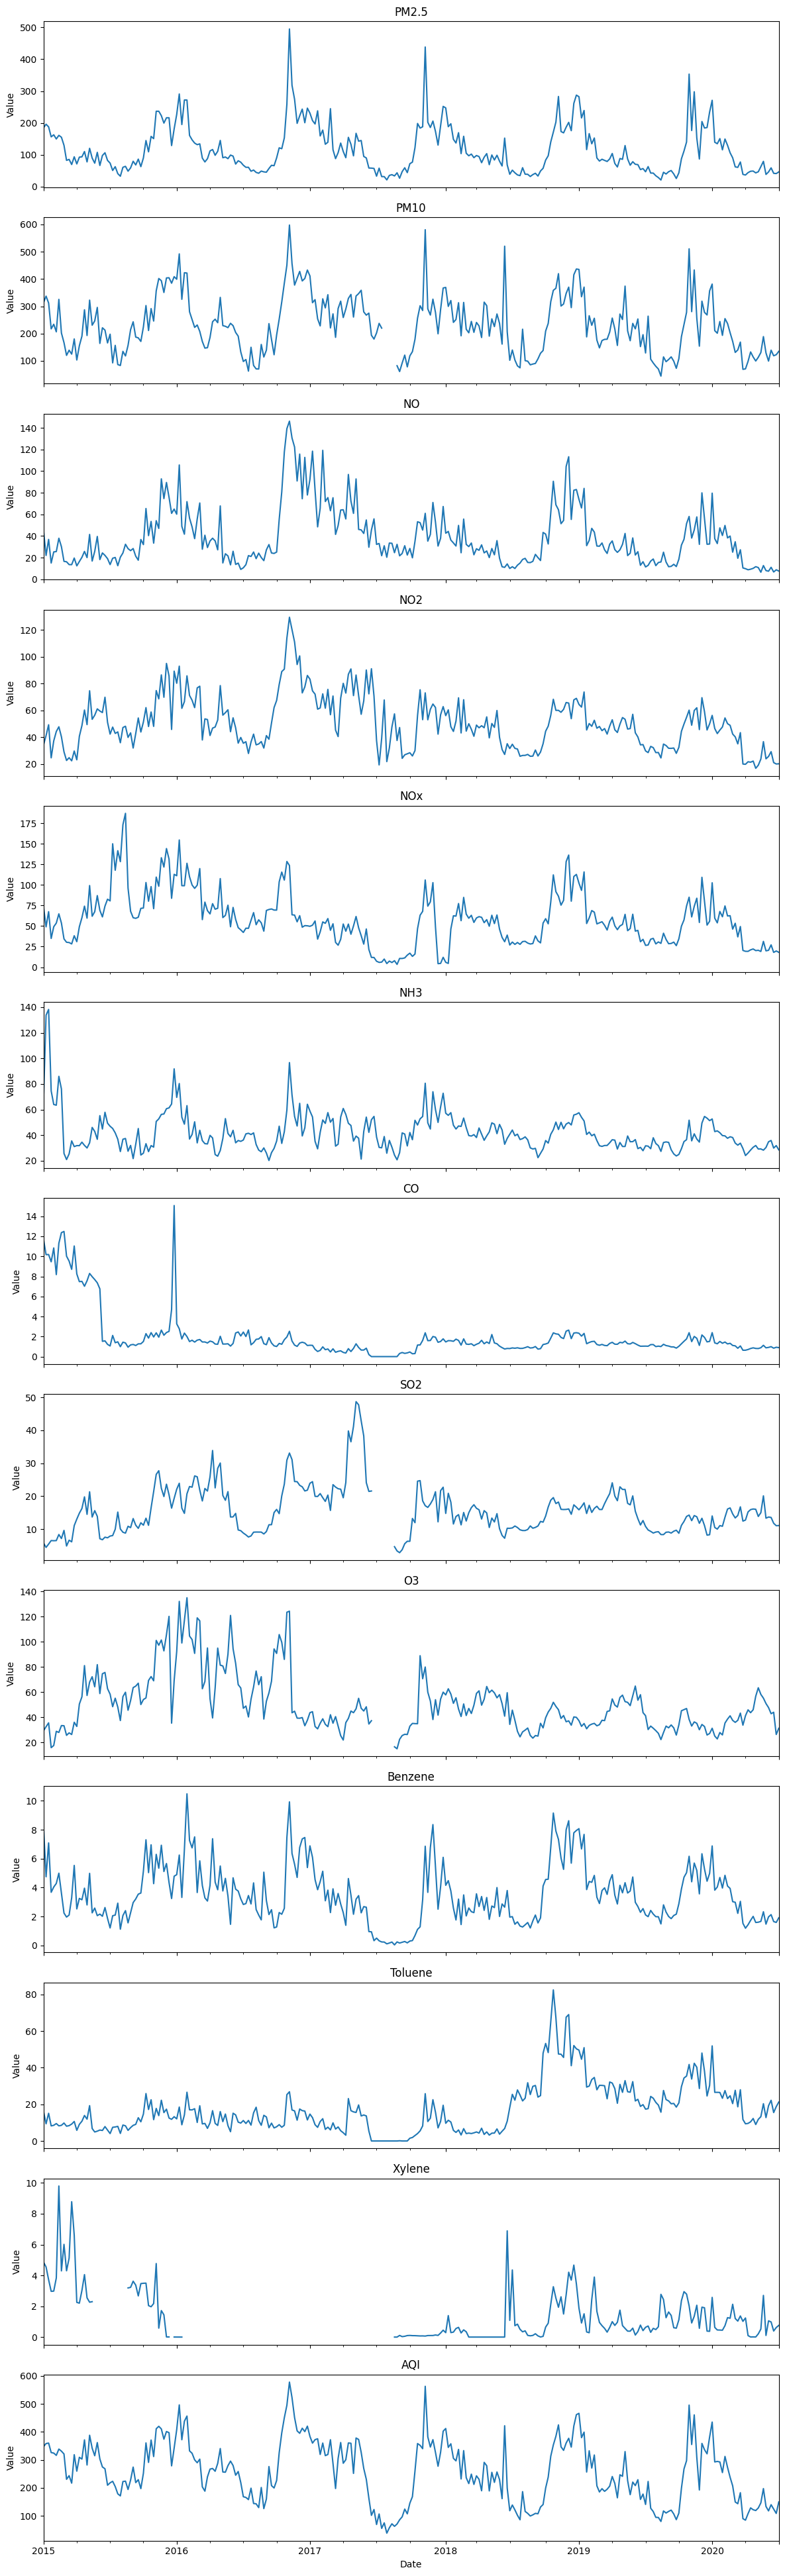

In [19]:
plot_numeric_columns(weekly_city_df, num_cols)

Analyzing data for ARIMA

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [21]:
find_gaps(weekly_city_df['AQI'])

No gaps.


In [22]:
# Last day in the dataset has missing values. Dropping it.
weekly_city_df.drop(index="2020-07-05", inplace=True)

In [23]:
decomp = seasonal_decompose(weekly_city_df['AQI'], period=52, model='additive', extrapolate_trend='freq')


Text(0.5, 0, 'Date')

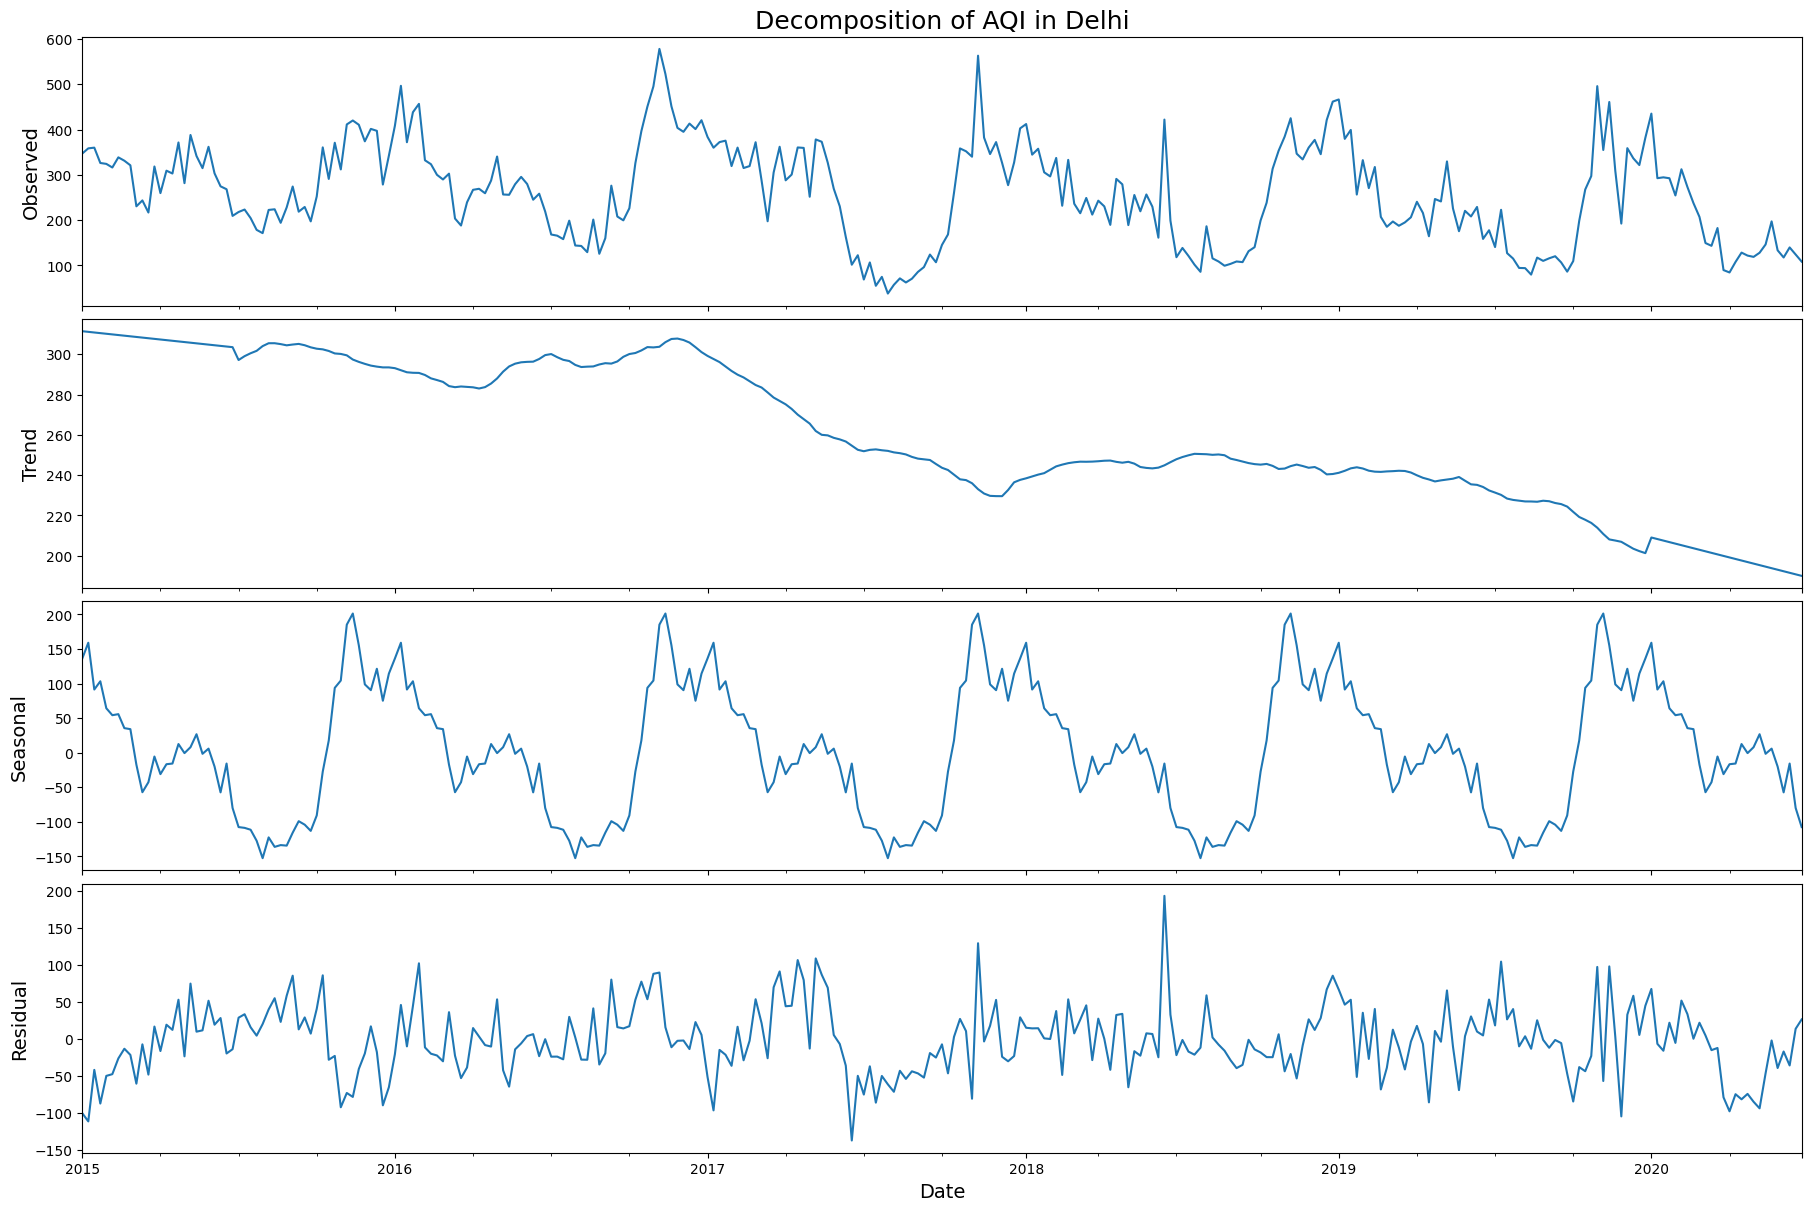

In [24]:
fig, ax = plt.subplots(
    nrows=4,
    ncols=1,
    sharex=True,
    figsize=(18, 12),
    constrained_layout=True
)

res = seasonal_decompose(
    weekly_city_df['AQI'],
    period=52,
    model='additive',
    extrapolate_trend='freq'
)

ax[0].set_title('Decomposition of AQI in Delhi', fontsize=18)
res.observed.plot(ax=ax[0], legend=False)
ax[0].set_ylabel('Observed', fontsize=14)
# ax[0].set_ylim([-5, 35])

res.trend.plot(ax=ax[1], legend=False)
ax[1].set_ylabel('Trend', fontsize=14)
# ax[1].set_ylim([-5, 35])

res.seasonal.plot(ax=ax[2], legend=False)
ax[2].set_ylabel('Seasonal', fontsize=14)
# ax[2].set_ylim([-15, 15])

res.resid.plot(ax=ax[3], legend=False)
ax[3].set_ylabel('Residual', fontsize=14)
# ax[3].set_ylim([-15, 15])

ax[3].set_xlabel('Date', fontsize=14)

In [26]:
arima_model = auto_arima(y=weekly_city_df['AQI'], start_p=1, start_P=1, start_q=1, \
                         start_Q=1, seasonal=True, m=52, stepwise=True)
print(f"Arima model summary:\n{arima_model.summary()}")

Arima model summary:
                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  287
Model:             SARIMAX(0, 1, 1)x(0, 0, [1, 2], 52)   Log Likelihood               -1561.019
Date:                                 Tue, 06 Jan 2026   AIC                           3130.038
Time:                                         16:49:22   BIC                           3144.662
Sample:                                     01-04-2015   HQIC                          3135.900
                                          - 06-28-2020                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4100      0.045     -9.032      0.00

In [29]:
model = SARIMAX(weekly_city_df['AQI'], order=(0,1,1), seasonal_order=(0,0,[1,2],52), trend='n')

In [30]:
model_results = model.fit()
print(model_results.summary())

c:\Users\Ryan\anaconda3\envs\aqi_venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


                                        SARIMAX Results                                        
Dep. Variable:                                     AQI   No. Observations:                  287
Model:             SARIMAX(0, 1, 1)x(0, 0, [1, 2], 52)   Log Likelihood               -1561.019
Date:                                 Tue, 06 Jan 2026   AIC                           3130.038
Time:                                         18:25:20   BIC                           3144.662
Sample:                                     01-04-2015   HQIC                          3135.900
                                          - 06-28-2020                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4100      0.045     -9.032      0.000      -0.499      -0